 # Craigslist Capstone Project - Modeling

#### The goal of this capstone is to predict market rent prices in the San Francisco Bay Area. The metros of interest are San Francisco, Peninsula, East Bay.

Prior to this notebook, the preprocessing was performed and numeric data was scaled. Training and test data have been split.

#### This notebook covers the scope of
1. Building a Linear Regression Model
2. Building a Random Forest Model
3. Build a Gradient Boosted Regressor

## Importing the libraries

In [1]:
import pandas as pd
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn import __version__ as sklearn_version
from sklearn.linear_model import ElasticNet, LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, confusion_matrix, r2_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, cross_val_score
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split, cross_validate, learning_curve
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.dummy import DummyRegressor
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_regression

## Load Data

In [2]:
# The data is the interim directory
df = pd.read_csv('/Users/pandabear/springboard/CapstoneTwoProject/data/interim/listing_df_EDA.csv',index_col='listing_id')
# Drop listing_city 
df.drop(['listing_city'], axis=1, inplace=True)
df

,listing_nh,listing_price,listing_sqft,listing_address,animals_cats,animals_dogs,smoking,wheelchair accessible,has_AC,hasEVCharging,...,pets_allowed,has_amenities,premium_finishes,ensuite_bath,has_balcony,has_backyard,has_view,multi-level,no_bedrooms,no_bathrooms
listing_id,,,,,,,,,,,,,,,,,,,,,
7495842903,palo alto,1695,400.0,Charleston near Alma,0,0,0,0,0,0,...,1,1,0,0,0,0,0,0,1,1.0
7495939664,sunset / parkside,3195,NaN,1311 La Playa Street near Irving Street,1,1,1,0,0,0,...,0,1,0,0,0,0,1,0,1,1.0
7495966009,mission district,4999,927.0,555 Florida St. near Mariposa,0,0,0,0,0,0,...,1,1,0,0,0,0,0,0,1,1.0
7496082921,oakland east,2125,505.0,3030 Chapman Street near derby,1,1,1,0,0,0,...,0,1,0,1,1,0,1,0,0,1.0
7496092147,oakland east,2350,NaN,3050 Fruitvale Ave.,0,0,0,0,0,0,...,1,1,0,0,0,0,0,0,2,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7544379148,oakland east,5095,1233.0,2330 Webster Street near 23rd Street,1,1,0,1,0,1,...,0,0,0,0,0,0,0,0,3,2.0
7544379723,danville / san ramon,2100,848.0,2311 Ivy Hill Way,1,1,1,0,1,0,...,0,1,0,0,0,0,1,0,1,1.0
7544384694,berkeley,2350,NaN,arch near virginia,0,0,1,0,0,0,...,0,1,0,0,0,1,1,0,2,1.5


In [3]:
y = df['listing_price']
X = df

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, 
                                                    random_state=1,shuffle=True)

In [4]:
nh_listings_test = X_train.groupby(['listing_nh','no_bedrooms'])['listing_price'].mean().reset_index()
nh_listings_test.rename(columns = {'listing_price':'average_price_by_nh_by_bedroom'}, inplace = True)
nh_listings_test

,listing_nh,no_bedrooms,average_price_by_nh_by_bedroom
0,SOMA / south beach,0,2557.380000
1,SOMA / south beach,1,3593.327778
2,SOMA / south beach,2,4820.675862
3,SOMA / south beach,3,5367.848485
4,SOMA / south beach,4,5789.000000
...,...,...,...
414,western addition,2,3503.750000
415,western addition,4,5250.000000
416,woodside,0,1575.000000
417,woodside,2,5500.000000


In [5]:
nh_listings_test['average_price_by_nh_by_bedroom'].mean()

4067.9277049294737

In [6]:
y_train.shape, y_test.shape

((9499,), (4071,))

In [7]:
# Save the index to put back after scaling
X_train_index = X_train.index
X_test_index = X_test.index

## 2. Handle missing values

In [8]:
missing = pd.concat([X_train.isnull().sum(), 100 * X_train.isnull().mean()], axis=1)
missing.columns=['count', '%']
missing.sort_values(by='count',ascending=False)

,count,%
listing_sqft,3069,32.308664
transit_score,1651,17.380777
bike_score,1171,12.327613
walk_score,268,2.821350
listing_address,249,2.621329
listing_nh,0,0.000000
pets_allowed,0,0.000000
housing_apt,0,0.000000
housing_flat,0,0.000000
housing_house,0,0.000000


The missing addresses are ok to ignore since we will not be using that feature directly. The neighborhood and walk_score, transit_score, bike_scores are better representations of how desirable a property is compared to the exact address.

### Impute any missing square footage values 
Let's use the median value for the listing's number of bedroom/bathroom

In [9]:
class ImputeMissingSqft:
        
    def fit(self, X, y=None):
        # Group by bedrooms and bathrooms to find median square footage
        self.missing_sqft = X.groupby(by=['no_bedrooms','no_bathrooms']).median()['listing_sqft'].reset_index()
        self.missing_sqft.rename(columns = {'listing_sqft':'listing_sqft_median'}, inplace = True)
        mean_sqft_by_bedroom = self.missing_sqft.groupby(by='no_bedrooms').mean().reset_index()[['no_bedrooms','listing_sqft_median']]
        
        # Create a dictionary of the average sqft by bedrooms
        self.mean_sqft_by_bedroom_dict = mean_sqft_by_bedroom.set_index('no_bedrooms').to_dict()['listing_sqft_median']
        
        # Fillna for the missing values in the dictionary
        self.missing_sqft.loc[self.missing_sqft['listing_sqft_median'].isnull(),'listing_sqft_median'] = self.missing_sqft['no_bedrooms'].map(self.mean_sqft_by_bedroom_dict)
        return self
    
    def transform(self, X):
        # Left join on bedrooms and bathrooms and use the median column if listing_sqft is null
        combined_df = X.merge(self.missing_sqft, on=['no_bedrooms','no_bathrooms'], how='left')
        
        combined_df['listing_sqft'].fillna(combined_df['listing_sqft_median'], inplace=True)
        
        # Fillna with the median listing_sqft value by bedroom only if it is a combination not seen before
        combined_df['listing_sqft'].fillna(combined_df['no_bedrooms'].map(self.mean_sqft_by_bedroom_dict), inplace=True)
        
        # Drop the extra column
        combined_df.drop(['listing_sqft_median'], axis=1, inplace=True)
        X = combined_df
        return X

### Impute any missing Walk score, Transit Score, Bike Score values
Let's use the median value for the listing's neighborhood. All transit scores range from 0 to 100

In [10]:
class ImputeMissingWalkscore:
        
    def fit(self, X, y=None):
        # Group by neighborhood to find median walks_score, transit_score, bike_score
        self.median_scores = X.groupby(by=['listing_nh']).median()[['walk_score','transit_score','bike_score']].reset_index()
        self.median_scores.rename(columns = {'walk_score':'median_walk_score','transit_score':'median_transit_score','bike_score':'median_bike_score'}, inplace = True)
        self.median_scores.fillna(0, inplace=True)
        return self
    
    def transform(self, X):
        # Left join on neighborhoods
        nh_df = X.merge(self.median_scores, on=['listing_nh'], how='left')

        # Use the mean score values if walk_score, transit_score or bike_score is null
        nh_df['walk_score'].fillna(nh_df['median_walk_score'],inplace=True)
        nh_df['transit_score'].fillna(nh_df['median_transit_score'],inplace=True)
        nh_df['bike_score'].fillna(nh_df['median_bike_score'],inplace=True)

        # In case there is a new neighborhood that doesn't have a mean walk/bike/transit score, use the mean of median_scores to fill null values
        nh_df['walk_score'].fillna(self.median_scores['median_walk_score'].mean(),inplace=True)
        nh_df['transit_score'].fillna(self.median_scores['median_transit_score'].mean(),inplace=True)
        nh_df['bike_score'].fillna(self.median_scores['median_bike_score'].mean(),inplace=True)
        
        # Drop unused columns
        nh_df.drop(['median_walk_score','median_transit_score','median_bike_score','listing_address'], axis=1,inplace=True)

        X = nh_df
        return X

## 4. Remove outliers
### For studio listings
During EDA, it became clear that studio listing prices had a very long tail - possibly because some listings were misclassified as studios when they should have been 1 or 2 bedroom apartments. 
To remove these outliers, cap the prices of studios to the 99th percentile

In [11]:
class RemoveOutliersStudios:
    def fit(self, X, y=None):
        # Cap the top 1% percentile of all listing_price for studios
        self.upper_lim = X[X['no_bedrooms'] == 0]['listing_price'].quantile(q = 0.99)
        return self
    
    def transform(self, X):
        X.loc[(X['listing_sqft'] > self.upper_lim) & (X['no_bedrooms'] == 0),'listing_price'] = self.upper_lim
        # Drop listing_price column
        X.drop(['listing_price'], axis=1, inplace=True)
        
        return X

### For listing square footage grouped by number of bedrooms

In [12]:
class CapOutliersSquareFootageByBedroom:
    def fit(self, X, y=None):
        grouped_bed_median = X.groupby(by=['no_bedrooms']).median()[['listing_sqft']].reset_index()
        grouped_bed_std = X.groupby(by=['no_bedrooms']).std()[['listing_sqft']].reset_index()
        self.sqft = pd.merge(grouped_bed_median, grouped_bed_std, on = "no_bedrooms", how = "inner")
        self.sqft.rename(columns = {'listing_sqft_x':'median_sqft', 'listing_sqft_y':'std_sqft'}, inplace = True)
        
        # Calculate the upper limit
        self.sqft['upper_lim'] = self.sqft.apply(lambda row: row['median_sqft'] + row['std_sqft'] * 3, axis = 1).astype(int)
        return self
    
    def transform(self, X):
        X = X.merge(self.sqft[['no_bedrooms','upper_lim']], on=['no_bedrooms'], how='left')
        X['listing_sqft'] = np.where((X['listing_sqft'] > X['upper_lim']), X['upper_lim'], X['listing_sqft'])
        # Drop upper_lim column
        X.drop(['upper_lim'], axis=1, inplace=True)
        return X

## 3. Feature engineering for categorical variables
The remaining categorical features are neighborhood and city. Since a city includes multiple neighborhoods, we can use the neighborhood feature in lieu of the city feature entirely. 
The most common size of rental units are 1 bedroom/1 bathroom ones. There are too many neighborhoods to one hot encode so instead impute using the mean price per 1 bedroom/1 bathroom listing for that neighborhood or city. 

Let's create or own Estimator to replace the categorical feature neighborhoods to the average listing price of 1 bedroom/1 bathroom places for each neighborhood. 

In [13]:
# List all the unique neighborhoods in the entire dataset
unique_nh = df.listing_nh.unique()
print(f'There are {len(unique_nh)} unique neighborhoods in the dataframe')

There are 81 unique neighborhoods in the dataframe


In [14]:
class NHAveragePrice:

# # Option 1: Group by neighborhood and number of bedrooms
#     def fit(self, X, y=None):
#         # Group by neighborhood and number of bedrooms
#         self.nh_listings = X.groupby(['listing_nh','no_bedrooms'])['listing_price'].mean().reset_index()
#         self.nh_listings.rename(columns = {'listing_price':'average_price_by_nh_by_bedroom'}, inplace = True)
        
#         return self
    
#     def transform(self, X):
#         combined_df = X.merge(self.nh_listings, on=['listing_nh','no_bedrooms'], how='left')
#         combined_df.rename(columns = {'listing_price_y':'average_price_by_nh_by_bedroom'}, inplace = True)
        
#         # If there is a combination of neighborhood and bedroom number not seen in the training set, impute the median price
#         combined_df['average_price_by_nh_by_bedroom'].fillna(self.nh_listings['average_price_by_nh_by_bedroom'].mean(), inplace=True)
#         X = combined_df
#         return X
    
# Option 2: Group by neighborhood and square footage

    def fit(self, X, y=None):
        # Group by neighborhood and square footage
        X['price_per_sqft'] = X['listing_price']/X['listing_sqft']
        self.nh_price = X.groupby(['listing_nh'])['price_per_sqft'].mean().reset_index()
        X.drop(['price_per_sqft'], axis=1, inplace=True)

        return self
    
    def transform(self, X):
        avg_nh_df = X.merge(self.nh_price, on=['listing_nh'], how='left')
        
        # If there is a neighborhood not seen in the training set, impute the median value for all neighborhoods
        avg_nh_df['price_per_sqft'].fillna(self.nh_price['price_per_sqft'].median(), inplace=True)
  
        avg_nh_df.drop(['listing_nh'], axis=1,inplace=True)
        X = avg_nh_df
        return X


## 6. Standardize numeric features

In [15]:
class DataframeMinMaxScaler:
    def __init__(self, columns):
        self.columns = columns
        self.scaler = MinMaxScaler()
        
    def fit(self, X, y=None):
        self.scaler.fit(X[self.columns])
        return self
    
    def transform(self, X):
        X[self.columns] = self.scaler.transform(X[self.columns])
        return X

In [16]:
nh = NHAveragePrice()
sqft1 = ImputeMissingSqft()
walk = ImputeMissingWalkscore()
outliers = RemoveOutliersStudios()
sqft2 = CapOutliersSquareFootageByBedroom()
scale = DataframeMinMaxScaler(['listing_sqft','walk_score','transit_score','bike_score','no_bedrooms','no_bathrooms','price_per_sqft'])

p = Pipeline([
    ('impute_missing_sqft', sqft1),
    ('impute_missing_walkscore', walk),
    ('nh_average_price', nh),
    ('remove_outliers_studios', outliers),
    ('Cap_Outliers_Square_Footage_By_Bedroom', sqft2),
    ('min_max_scaler', scale)
])

X_train = p.fit_transform(X_train)
X_test = p.transform(X_test)

In [17]:
# Assign index back
X_train.index = X_train_index
X_test.index = X_test_index
X_train

,listing_sqft,animals_cats,animals_dogs,smoking,wheelchair accessible,has_AC,hasEVCharging,laundry_in_bldg,laundry_in_unit,laundry_has_hookup,...,has_amenities,premium_finishes,ensuite_bath,has_balcony,has_backyard,has_view,multi-level,no_bedrooms,no_bathrooms,price_per_sqft
listing_id,,,,,,,,,,,,,,,,,,,,,
7522325421,0.355343,1,1,0,0,1,0,0,1,0,...,1,0,1,0,0,0,0,0.666667,0.714286,0.342449
7512600118,0.083532,1,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0.166667,0.142857,0.579270
7520907681,0.334129,1,1,0,0,1,1,0,1,0,...,1,0,0,0,1,0,0,0.333333,0.428571,0.241255
7535823556,0.219305,1,1,1,0,0,1,0,1,0,...,1,0,0,0,0,0,0,0.333333,0.142857,0.810154
7527700403,0.317953,1,1,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0.500000,0.428571,0.639456
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7509800453,0.216123,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.166667,0.142857,0.466742
7522272740,0.364625,0,0,1,1,0,0,0,1,0,...,1,0,0,0,0,1,0,0.500000,0.571429,0.810154
7542195751,0.169716,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0.333333,0.142857,0.241255


In [18]:
print(f'There are {X_train.isnull().sum().sum()} missing rows in X_train')
print(f'There are {X_test.isnull().sum().sum()} missing rows in X_test')

There are 0 missing rows in X_train
There are 0 missing rows in X_test


## 1. Linear Regression

In [19]:
regr = LinearRegression()
regr.fit(X_train, y_train)
print(f'Coefficient of determination of training set: {regr.score(X_train, y_train):.2f}')
print(f'Coefficient of determination of test set: {regr.score(X_test, y_test):.2f}')

Coefficient of determination of training set: 0.73
Coefficient of determination of test set: 0.72


In [20]:
param_grid = { 
    'alpha': [1e-2, 1e-3, 1e-4, 1e-5, 1e-6],
}

cv = GridSearchCV(estimator=ElasticNet(max_iter=100000, warm_start=True, tol=1e-4), param_grid=param_grid, cv=5, refit=True)
cv.fit(X_train, y_train)

# Apply RF to the training data:
regr = cv.best_estimator_

print(f'Cross Validation best parameters: {cv.best_params_}')
print(f'Coefficient of determination of training set: {regr.score(X_train, y_train):.2f}')
print(f'Coefficient of determination of test set: {regr.score(X_test, y_test):.2f}')

/Users/pandabear/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.010e+07, tolerance: 1.682e+06
  model = cd_fast.enet_coordinate_descent(
/Users/pandabear/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.101e+07, tolerance: 1.631e+06
  model = cd_fast.enet_coordinate_descent(
/Users/pandabear/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing 

Cross Validation best parameters: {'alpha': 0.0001}
Coefficient of determination of training set: 0.73
Coefficient of determination of test set: 0.72


The coefficient of determination for the test set is close to the training set, which suggests the model has low variance.

In [21]:
# Predict price from X_test
y_pred_lr = regr.predict(X_test)

In [22]:
#scores = cross_val_score(regr, X_test, y_test, cv=5)
#print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

In [23]:
print(f'MAE test: {mean_absolute_error(y_test, y_pred_lr):.2f}')
print(f'RMSE test: {mean_squared_error(y_test, y_pred_lr, squared=False):.2f}')
print(f'R2 score: {r2_score(y_test, y_pred_lr):.2f}')

MAE test: 533.05
RMSE test: 824.12
R2 score: 0.72


Interpretation of these metrics: On average, the MAE is 533 dollars away from the predicted value. The RMSE value is high and reflective of the right-skewness of the target variable.

## Plot the residuals between predicted price and actual price

Text(0.5, 1.0, 'Residual Density for Linear Regression in dollar amount')

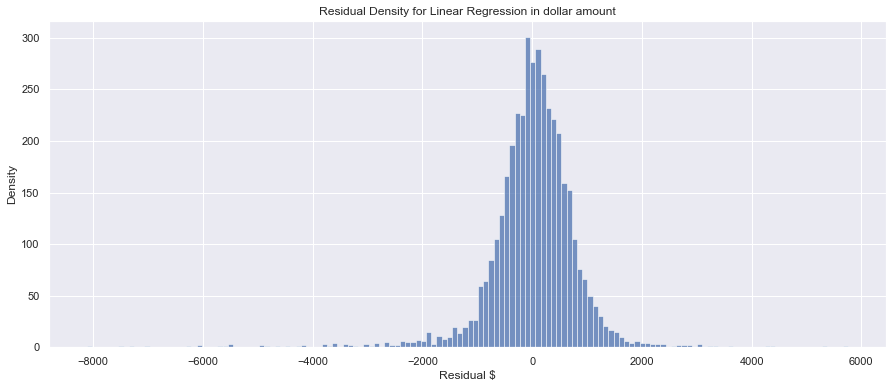

In [24]:
residuals_as_prices = y_pred_lr - y_test
# Plot test set with missing sqft that was imputed
sns.set(rc={"figure.figsize":(15, 6)})
s = sns.histplot(residuals_as_prices)
plt.ylabel('Density')
plt.xlabel('Residual $')
plt.title('Residual Density for Linear Regression in dollar amount')

There seems to be a long left tail where the model is predicting higher prices for a listing than the actual price.
Let's look into the proportions of residual distribution. Define a low residual as one where the model has closely predicted the listing price. A medium residual to be an ok prediction but off by a few hundred, and a high residual as a predicted value that wouldn't help inform the user. 

In [25]:
# Take a closer look at why the data with high residuals
X_test_size = X_test.shape[0]

low_residual = 100
med_residual = 500
high_residual = 1000

# Also useful to compare percentages of the listing price
low_residual_percent = 0.15
residual = pd.DataFrame(y_pred_lr - y_test)

residual.rename(columns = {'listing_price':'price_residual'}, inplace = True)


In [26]:
residual['listing_price'] = y_test
residual['residual_percent'] = residual['price_residual']/residual['listing_price']
residual['residual_category'] = np.where(np.abs(residual['residual_percent'])<low_residual_percent, 'Within_15_percent', 'More_than_15_percent')
residual

,price_residual,listing_price,residual_percent,residual_category
listing_id,,,,
7516091581,318.414354,2300,0.138441,Within_15_percent
7516881630,-350.462747,1700,-0.206155,More_than_15_percent
7542231341,537.159333,4250,0.126390,Within_15_percent
7519496408,304.014342,2050,0.148300,Within_15_percent
7510358529,-2007.385661,9495,-0.211415,More_than_15_percent
...,...,...,...,...
7533952282,-685.216788,3600,-0.190338,More_than_15_percent
7541234736,213.321718,5000,0.042664,Within_15_percent
7541424042,-384.816483,2758,-0.139527,Within_15_percent


/Users/pandabear/opt/anaconda3/lib/python3.9/site-packages/seaborn/_core.py:1057: FutureWarning: reindexing with a non-unique Index is deprecated and will raise in a future version.
  comp_col.loc[orig.index] = pd.to_numeric(axis.convert_units(orig))


ValueError: cannot reindex on an axis with duplicate labels

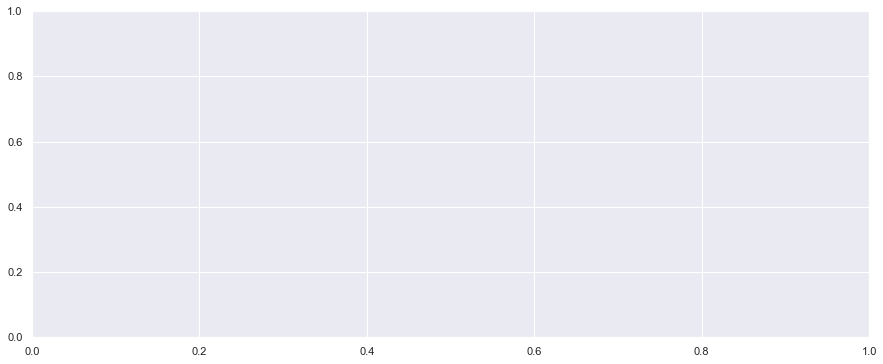

In [27]:
# Plot the distribution of residuals as a percentage
sns.set(rc={"figure.figsize":(15, 6)})
s = sns.histplot(data = residual, x='residual_percent', hue='residual_category')
plt.ylabel('Density')
plt.xlabel('Residual %')
plt.title('Residual Density as a proportion of listing price for Linear Regression')

In [28]:
# Look at the high_residual rows
index_of_interest_high = residual[(residual['price_residual'] > high_residual) | (residual['price_residual'] < -high_residual)].index
print(f'X_test with missing square footage values imputed:')
print(f'There are {len(index_of_interest_high)} rows that have residuals greater than {high_residual} between actual and predicted price, which is {(len(index_of_interest_high)/X_test_size)*100:.1f}%')

# Look at the med_residual rows
index_of_interest_med = residual[(residual['price_residual'] < med_residual) & (residual['price_residual'] > -med_residual)].index
print(f'There are {len(index_of_interest_med)} rows that have residuals less than {med_residual} between actual and predicted price, which is {(len(index_of_interest_med)/X_test_size)*100:.1f}%')

# Look at the low_residual rows
index_of_interest_low = residual[(residual['price_residual'] > -low_residual) & (residual['price_residual'] < low_residual)].index
print(f'There are {len(index_of_interest_low)} rows that have residuals less than {low_residual} between actual and predicted price, which is {(len(index_of_interest_low)/X_test_size)*100:.1f}%')

# Get index of rows of interest, where residual is greater than med_residual ######
index_of_interest = residual[(residual['price_residual'] < -med_residual) | (residual['price_residual'] > med_residual)].index




X_test with missing square footage values imputed:
There are 463 rows that have residuals greater than 1000 between actual and predicted price, which is 11.4%
There are 2522 rows that have residuals less than 500 between actual and predicted price, which is 62.0%
There are 603 rows that have residuals less than 100 between actual and predicted price, which is 14.8%


In [29]:
# Get listing_ids of rows of interest
listing_ids_residuals = X_test.iloc[index_of_interest,:].index

# Get list of predicted values
pred_values = []
for i in index_of_interest:
    pred_values.append(y_pred_lr[i])
    
# Create a dictionary of listing_ids as keys and predicted values as values
dict_cases = dict(zip(listing_ids_residuals,pred_values))

# Or a df of the listing_ids and predicted values
listing_pred = pd.DataFrame(data =pred_values,index = listing_ids_residuals, columns = ['y_pred'])
listing_pred

IndexError: positional indexers are out-of-bounds

In [30]:
# Load entire df after preprosessing but before minmax scaling to look at individual listings that have high residuals
df_nonscaled = pd.read_csv('/Users/pandabear/springboard/CapstoneTwoProject/data/interim/combined_DF_MODEL.csv',index_col='listing_id')
df_nonscaled

,listing_sqft,animals_cats,animals_dogs,smoking,wheelchair accessible,has_AC,hasEVCharging,laundry_in_bldg,laundry_in_unit,laundry_has_hookup,...,premium_finishes,ensuite_bath,has_balcony,has_backyard,has_view,multi-level,no_bedrooms,no_bathrooms,price_per_sqft,listing_price
listing_id,,,,,,,,,,,,,,,,,,,,,
7522325421,1500.0,1,1,0,0,1,0,0,1,0,...,0,1,0,0,0,0,4,3.0,2.739584,4100
7512600118,475.0,1,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,1,1.0,3.613467,2600
7520907681,1420.0,1,1,0,0,1,1,0,1,0,...,0,0,0,1,0,0,2,2.0,2.366175,2200
7535823556,987.0,1,1,1,0,0,1,0,1,0,...,0,0,0,0,0,0,2,1.0,4.465442,3980
7527700403,1359.0,1,1,1,0,0,0,0,1,0,...,0,0,0,0,0,0,3,2.0,3.835557,3695
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7533952282,1200.0,0,0,0,0,0,0,0,0,1,...,1,0,0,0,1,0,3,1.5,3.105383,3600
7541234736,2030.0,0,0,1,0,1,0,0,1,0,...,1,0,0,1,1,0,4,2.5,2.919049,5000
7541424042,680.0,1,1,1,0,1,1,0,1,0,...,0,0,1,0,0,0,1,1.0,2.941171,2758


In [31]:
#dict(zip(df.apply(lambda row: '{}|{}'.format(row.listing_nh, row.no_bedrooms), axis=1), df['listing_price']))

In [32]:
#problematic_df = df.loc[listing_ids_residuals]

In [33]:
# Look at residuals as a percentage of listing price

# Add 2 columns: predicted price from the model, and residual
residuals_df = pd.merge(listing_pred, df_nonscaled, on = 'listing_id', how = 'left')

residuals_df['actual-pred'] = residuals_df['listing_price'] - residuals_df['y_pred']
residuals_df['residual_percentage'] = residuals_df['actual-pred']/residuals_df['listing_price']

# Only look at rows that have listing_sqft i.e. it was not imputed
residuals_df = residuals_df[residuals_df.listing_sqft.notnull()]


NameError: name 'listing_pred' is not defined

In [34]:
residuals_df.head()

NameError: name 'residuals_df' is not defined

In [35]:
# Plot the residuals on a boxplot, grouped by number of bedrooms
sns.boxplot(data=residuals_df, y ='residual_percentage',x='no_bedrooms', hue='no_bedrooms')

NameError: name 'residuals_df' is not defined

The prediction accuracy tends to get worse as the number of bedrooms increases, which is expected for more expensive properties. Another way to segment the listings would be by square footage.

In [ ]:
# Plot the residuals on a boxplot, grouped by bins of square footage values
residuals_df['sqft_bins'] = pd.cut(residuals_df['listing_sqft'], bins=[0, 1000, 2000, 3000, float('Inf')], labels=['Below 1000', '1001-2000','2001-3000','3001+'])
sns.boxplot(data=residuals_df, y ='residual_percentage',x='sqft_bins', hue='sqft_bins')

In [ ]:
# Focus on residuals greater than 50%
residuals_50 = residuals_df[(residuals_df['residual_percentage'] > 0.5) | (residuals_df['residual_percentage'] < -0.5)]
print(f'There are {residuals_50.shape[0]} rows that had residuals greater than 50%')
residuals_50

In [ ]:
# Plot the distribution of square footage as a histogram
residuals_50.listing_sqft.hist(figsize=(10,5), bins=20)


In [ ]:

sns.countplot(data=residuals_50, x="no_bedrooms")

In [ ]:
sns.countplot(data=residuals_50, x="no_bathrooms")

In [ ]:
# Plot the distribution of residuals over 50%
residual_distribution = residuals_50.residual_percentage.hist(figsize=(10,5), bins=20)
residual_distribution.title("Distribution of residuals over 50%")


In [ ]:
sns.histplot(data=residuals_50, x="residual_percentage", kde=True)

## 2. Random Forest Regressor

In [ ]:
param_grid = { 
    'n_estimators': [100, 200],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6]
}

CV_rf = GridSearchCV(estimator = RandomForestRegressor(), param_grid = param_grid, cv = 5, refit = True)
CV_rf.fit(X_train, y_train)

# Apply RF to the training data:
rf = CV_rf.best_estimator_

print(f'Cross Validation best parameters: {CV_rf.best_params_}')

In [ ]:
# Predict using the model:
y_pred = rf.predict(X_test)

# Accuracy score
print(f'Accuracy for Random Forest on CV data: {rf.score(X_test,y_test):.2f}')

## 3. Gradient Boosting Regressor

In [ ]:
n_features = X_train.shape[1]
gb = GradientBoostingRegressor(random_state = 0)

distributions = dict(learning_rate = [0.05, 0.1, 0.25, 0.5, 0.75, 1, 1.25, 1.5], 
                    max_depth = [1,2,3,4,5],
                     max_features = np.arange(1, n_features, 1),
                    n_estimators = [20,40,60,80,100,125,150])

gb_randomsearch = RandomizedSearchCV(gb, distributions, random_state=0)
search = gb_randomsearch.fit(X_train, y_train)

print(f'Random Search best parameters: {search.best_params_}')

In [ ]:
gb = GradientBoostingRegressor(n_estimators=150, learning_rate = 0.75, max_depth = 2, max_features = 2, random_state = 0)

gb.fit(X_train, y_train)

gb.predict(X_test)

gb_score = gb.score(X_test, y_test)
print(f'Gradient Boosting score: {gb_score}')

In [ ]:
sns.set(rc={"figure.figsize":(15, 6)})
g = sns.histplot(y_pred-y_test)
plt.ylabel('Density')
plt.xlabel('Residual $')
plt.title('Residual Density')

# Feature Exploration

Look at the linear regression model and the feature coefficients to see if they make sense

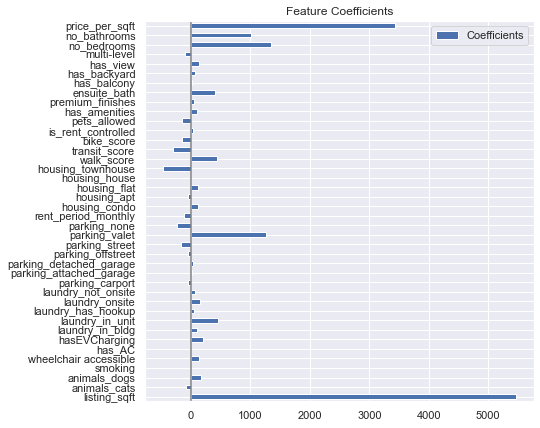

In [36]:
coefs = pd.DataFrame(
   regr.coef_,
   columns=['Coefficients'], index=X_train.columns
)

coefs.plot(kind='barh', figsize=(9, 7))
plt.title('Feature Coefficients')
plt.axvline(x=0, color='.5')
plt.subplots_adjust(left=.3)

In [37]:
regr.coef_

array([5469.3200553 ,  -88.79229178,  162.27708549,  -12.83254086,
        131.80626092,  -10.21601344,  202.80998936,  100.40735916,
        451.09176694,   56.25993115,  147.33606072,   66.98855841,
        -42.37455966,   20.3780125 ,   34.64896561,  -47.21667832,
       -162.87956364, 1261.17759457, -235.538671  , -108.5870134 ,
        112.03656857,  -47.70727267,  113.42482364,   -7.25714398,
       -476.3389545 ,  439.44802939, -307.96144871, -157.55427776,
         31.5201288 , -151.76297939,  110.25189984,   43.15175206,
        402.11185986,   17.80884463,   64.598419  ,  139.02913841,
       -107.84266851, 1354.77796765, 1004.01170358, 3438.17745109])

In [38]:
X_train.head(8)

,listing_sqft,animals_cats,animals_dogs,smoking,wheelchair accessible,has_AC,hasEVCharging,laundry_in_bldg,laundry_in_unit,laundry_has_hookup,...,has_amenities,premium_finishes,ensuite_bath,has_balcony,has_backyard,has_view,multi-level,no_bedrooms,no_bathrooms,price_per_sqft
listing_id,,,,,,,,,,,,,,,,,,,,,
7522325421,0.355343,1,1,0,0,1,0,0,1,0,...,1,0,1,0,0,0,0,0.666667,0.714286,0.342449
7512600118,0.083532,1,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0.166667,0.142857,0.579270
7520907681,0.334129,1,1,0,0,1,1,0,1,0,...,1,0,0,0,1,0,0,0.333333,0.428571,0.241255
7535823556,0.219305,1,1,1,0,0,1,0,1,0,...,1,0,0,0,0,0,0,0.333333,0.142857,0.810154
7527700403,0.317953,1,1,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0.500000,0.428571,0.639456
7542444037,0.385574,1,1,1,0,0,0,1,0,0,...,1,1,0,0,0,0,0,0.333333,0.285714,0.435157
7533575490,0.275789,0,0,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0.500000,0.142857,0.373786
7539602500,0.222753,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0.666667,0.428571,0.342449


In [39]:
y_train.head(8)

listing_id
7522325421    4100
7512600118    2600
7520907681    2200
7535823556    3980
7527700403    3695
7542444037    2960
7533575490    2695
7539602500    2252
Name: listing_price, dtype: int64

In [40]:
def explain(model, X, y, listing_id):
    row = X.loc[listing_id]
    idx = X.index.get_loc(listing_id)
    y_actual = y[idx]
    y_pred = model.predict(X)[idx]
    contributions = [
        (feature, row[i] * model.coef_[i])
        for i, feature in enumerate(X.columns)
    ]
    print(f'y_actual : {y_actual}')
    print()
    print(f'y_pred : {y_pred}')
    print(f'intercept : {model.intercept_}')
    for feature, contribution in sorted(contributions, reverse=True, key=lambda c: abs(c[1])):
        if (abs(contribution)) > 0.1:
            print(f'{feature} : {contribution:.2f}')

Look at a specific listing to see the price contributions of each feature. In this case, the predicted price is lower than the actual listing price

In [50]:
#explain(regr, X_train, y_train, 7501999676)

In [49]:
#explain(regr, X_test, y_test, 7501999676)

In [43]:
regr.coef_

array([5469.3200553 ,  -88.79229178,  162.27708549,  -12.83254086,
        131.80626092,  -10.21601344,  202.80998936,  100.40735916,
        451.09176694,   56.25993115,  147.33606072,   66.98855841,
        -42.37455966,   20.3780125 ,   34.64896561,  -47.21667832,
       -162.87956364, 1261.17759457, -235.538671  , -108.5870134 ,
        112.03656857,  -47.70727267,  113.42482364,   -7.25714398,
       -476.3389545 ,  439.44802939, -307.96144871, -157.55427776,
         31.5201288 , -151.76297939,  110.25189984,   43.15175206,
        402.11185986,   17.80884463,   64.598419  ,  139.02913841,
       -107.84266851, 1354.77796765, 1004.01170358, 3438.17745109])

In [44]:
regr.feature_names_in_

array(['listing_sqft', 'animals_cats', 'animals_dogs', 'smoking',
       'wheelchair accessible', 'has_AC', 'hasEVCharging',
       'laundry_in_bldg', 'laundry_in_unit', 'laundry_has_hookup',
       'laundry_onsite', 'laundry_not_onsite', 'parking_carport',
       'parking_attached_garage', 'parking_detached_garage',
       'parking_offstreet', 'parking_street', 'parking_valet',
       'parking_none', 'rent_period_monthly', 'housing_condo',
       'housing_apt', 'housing_flat', 'housing_house',
       'housing_townhouse', 'walk_score', 'transit_score', 'bike_score',
       'is_rent_controlled', 'pets_allowed', 'has_amenities',
       'premium_finishes', 'ensuite_bath', 'has_balcony', 'has_backyard',
       'has_view', 'multi-level', 'no_bedrooms', 'no_bathrooms',
       'price_per_sqft'], dtype=object)

In [51]:
#df_nonscaled.loc[7501999676]

In [55]:
feature_coef_dict = {}

def get_feature_raw_coefficients(feature_transformer, model):
    features = model.feature_names_in_
    X_base = pd.DataFrame.from_records([[0]*len(features)], columns=features)
    y_base = model.predict(feature_transformer.transform(X_base))
    for i, feature in enumerate(features):
        feature_values = [[0]*len(features)]
        feature_values[0][i] = 1
        X = pd.DataFrame.from_records(feature_values, columns=features)
        y = model.predict(feature_transformer.transform(X))
#         print(f'{feature} : {y[0] - y_base[0]}')
        feature_coef_dict[feature] = y[0] - y_base[0]
    return feature_coef_dict
    
get_feature_raw_coefficients(scale, regr)

{'listing_sqft': 1.4503633135236669,
 'animals_cats': -88.79229178391415,
 'animals_dogs': 162.27708548781447,
 'smoking': -12.832540861065354,
 'wheelchair accessible': 131.80626092273542,
 'has_AC': -10.216013436182948,
 'hasEVCharging': 202.80998936340666,
 'laundry_in_bldg': 100.40735915999858,
 'laundry_in_unit': 451.09176694247253,
 'laundry_has_hookup': 56.25993114553694,
 'laundry_onsite': 147.33606072077646,
 'laundry_not_onsite': 66.98855841317163,
 'parking_carport': -42.374559660017894,
 'parking_attached_garage': 20.3780125044168,
 'parking_detached_garage': 34.64896560691841,
 'parking_offstreet': -47.21667831957075,
 'parking_street': -162.8795636447021,
 'parking_valet': 1261.1775945719608,
 'parking_none': -235.53867099521767,
 'rent_period_monthly': -108.5870133968715,
 'housing_condo': 112.03656857033093,
 'housing_apt': -47.70727267032271,
 'housing_flat': 113.42482364106081,
 'housing_house': -7.257143975753934,
 'housing_townhouse': -476.33895450063346,
 'walk_sco

### Look at the average contribution to the overall rental price of features of interest 
Features of interest:
* Allows pets
* Is wheelchair accessible
* Allows smoking
* Has Air Conditioning
* Has EV charging
* Has laundry in-unit
* Has offstreet parking
* Has Valet parking
* Has a high walk score/transit score (define high as ?, no car dependency)
* Has amenities
* Has premium finishes
* Has a backyard
* Has a view

In [102]:
# Convert dictionary to DataFrame
model_coef = pd.DataFrame(list(feature_coef_dict.items()))
model_coef.columns = ['feature','model_coef']
model_coef.set_index('feature', inplace=True)

model_coef

,model_coef
feature,
listing_sqft,1.450363
animals_cats,-88.792292
animals_dogs,162.277085
smoking,-12.832541
wheelchair accessible,131.806261
has_AC,-10.216013
hasEVCharging,202.809989
laundry_in_bldg,100.407359
laundry_in_unit,451.091767


In [112]:

    
features_of_interest = ['pets_allowed','smoking','wheelchair accessible','has_AC','hasEVCharging',
       'laundry_in_unit', 'parking_valet', 'has_amenities', 'premium_finishes', 'has_backyard', 'has_view']

model_coef = model_coef.loc[features_of_interest]

In [ ]:
# TO DO: CREATE WEIGHTED AVERAGES OF FEATURES TO PLOT








# Create a combined column of parking that is a designated parking location but not street parking
has_offstreet_parking = ['parking_carport', 'parking_attached_garage','parking_detached_garage', 'parking_offstreet']

# Create a column with high walk and transit score. High score meaning ???????
has_high_walk_transit_score = ['walk_score', 'transit_score']





















Text(0.5, 1.0, '$ Price change per 1 unit change in features')

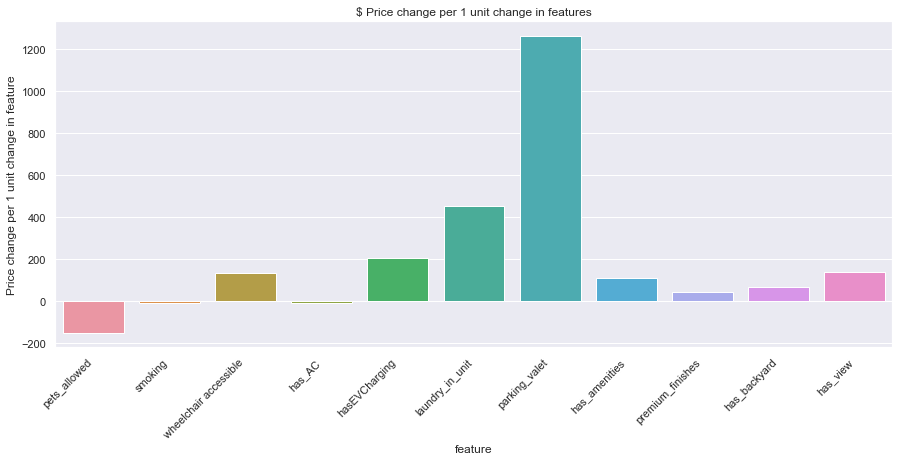

In [119]:
# Plot the model coefficients for each feature
chart = sns.barplot(data=model_coef.reset_index(), x="feature", y="model_coef")
chart.set_xticklabels(chart.get_xticklabels(), rotation=45, horizontalalignment='right')
chart.set_ylabel('Price change per 1 unit change in feature')
chart.set_title('$ Price change per 1 unit change in features')